In [9]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
from collections import deque
import time  # Asegúrate de importar este módulo

# Definir constantes
WINDOW_SIZE = 10           # Tamaño de la ventana deslizante
NUM_KEY_FRAMES = 5        # Número de frames clave a extraer
MOVEMENT_THRESHOLD = 0.3  # Umbral para detectar movimiento significativo
IOU_THRESHOLD = 0.5       # Umbral para evaluación de Intersection over Union

In [10]:
def get_facial_indices():
    # Frente y cejas
    indices_frente_cejas = [
        10, 67, 69, 104, 108, 109, 151, 334, 336, 337, 338, 
        9, 8, 55, 65, 70, 63, 105, 66, 107, 336, 296, 334, 293, 300, 
        276, 283, 282, 295, 285, 413, 441, 442, 445, 444, 443, 446, 261, 
        448, 449, 450, 451, 452, 453, 464, 453, 467, 260, 259, 257, 258, 286, 414, 463
    ]

    # Ojos
    indices_ojos = [
        33, 160, 158, 133, 153, 144, 362, 263, 387, 385, 380, 373,
        7, 163, 144, 145, 153, 154, 155, 173, 157, 158, 159, 160, 161, 246,
        33, 246, 161, 160, 159, 158, 157, 173, 133,
        362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382,
        159, 145, 385, 374, 386, 387, 388, 466, 263, 466, 388, 387, 386, 385, 384, 398,
        33, 133, 243, 190, 56, 28, 27, 29, 30, 247, 130, 25, 110, 24, 23, 22, 26, 112, 243,
        463, 414, 286, 258, 257, 259, 260, 467, 359, 255, 339, 254, 253, 252, 256, 341, 463
    ]

    # Nariz
    indices_nariz = [
        168, 6, 197, 195, 5, 4, 1, 2, 3, 49, 131, 134, 51, 5, 4, 195, 197, 196,
        419, 248, 281, 275, 274, 440, 360, 279, 392, 439, 358, 309, 129, 142,
        188, 189, 190, 56, 59, 278, 420, 399, 395, 369, 461, 354, 100, 127, 41, 128, 48, 64,
        6, 351, 169, 170, 140, 176, 148, 152, 377, 400, 378, 379, 365, 397, 288, 361, 323,
        454, 356, 389, 251, 284, 332, 297, 338
    ]

    # Mejillas y pómulos
    indices_mejillas_pomulos = [
        50, 101, 116, 117, 119, 118, 101, 205, 425, 350, 349, 429, 279, 330, 280, 425, 266, 426, 
        436, 432, 430, 394, 280, 346, 347, 329, 277, 343, 412, 351, 417, 285, 295, 282, 283, 276, 
        353, 437, 399, 419,
        111, 117, 118, 119, 120, 121, 128, 126, 142, 183, 184, 185, 187, 188, 411, 343, 277, 
        329, 330, 347, 348, 349, 350, 352, 417, 141, 94, 370
    ]

    # Boca y labios
    indices_boca = [
        0, 17, 13, 14, 402, 318, 324, 308, 292, 317, 14, 87, 178, 88, 95, 78, 191, 80, 81, 82, 
        13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95,
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146,
        76, 184, 74, 73, 72, 11, 302, 303, 304, 408, 306, 307, 320, 404, 315, 16, 85, 180, 90, 77,
        62, 183, 42, 41, 38, (0+17)//2, (269+270)//2, 291, 375, 321, 405, 414, 286, 258, 257, 259,
        61, 76, 62, 78, 95
    ]

    # Mandíbula y mentón
    indices_mandibula_menton = [
        152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 
        103, 67, 109, 10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 
        378, 400, 377,
        397, 288, 361, 323, 356, 389, 174, 175, 199, 200, 201, 202, 204, 208, 211, 32, 210, 212, 216, 426, 427, 
        428, 262, 431, 396
    ]

    # Líneas de expresión y arrugas
    indices_arrugas = [
        151, 175, 396, 369, 396, 175, 234, 93, 132, 58, 127, 162, 21, 54, 103,
        122, 196, 3, 51, 45, 48, 226, 4, 275, 440, 344, 278, 392, 289,
        35, 124, 111, 117, 50, 187, 207, 216, 212, 202, 204, 194, 201, 200,
        431, 262, 428, 199, 208, 32, 211, 210, 214, 216, 143, 156, 70, 63, 105, 66, 107
    ]

    # Combinamos todos los índices y eliminamos duplicados
    todos_indices = list(set(
        indices_frente_cejas + 
        indices_ojos + 
        indices_nariz + 
        indices_mejillas_pomulos + 
        indices_boca + 
        indices_mandibula_menton + 
        indices_arrugas
    ))

    # Asegurar que tengamos exactamente 291 puntos
    if len(todos_indices) < 291:
        # Agregamos puntos adicionales distribuidos uniformemente
        puntos_adicionales = [i for i in range(468) if i not in todos_indices]
        paso = max(1, len(puntos_adicionales) // (291 - len(todos_indices)))
        puntos_a_agregar = [puntos_adicionales[i] for i in range(0, len(puntos_adicionales), paso)][:291 - len(todos_indices)]
        todos_indices.extend(puntos_a_agregar)
    elif len(todos_indices) > 291:
        # Priorizar puntos importantes para expresiones faciales
        indices_prioritarios = (
            # Cejas y frente para AU1, AU2, AU4
            [70, 63, 105, 66, 107, 336, 296, 334, 293, 300, 27, 65, 55, 70, 46, 55, 65] + 
            # Ojos para AU5, AU6, AU7, AU43, AU45
            [33, 160, 133, 33, 7, 163, 144, 145, 153, 154, 158, 362, 385, 387, 263, 373] + 
            # Nariz para AU9, AU10, AU11
            [4, 5, 195, 197, 6, 122, 188, 209, 129, 49, 131, 134, 51, 5, 4, 195] + 
            # Boca para AU12, AU15, AU20, AU23, AU24, AU25, AU26, AU27
            [61, 37, 0, 267, 269, 270, 291, 321, 314, 17, 84, 314, 17, 84, 181, 91, 146, 61, 
             191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 76, 62, 96] + 
            # Mentón y mandíbula para AU17, AU20, AU26
            [18, 200, 199, 175, 152, 148, 176, 149, 150]
        )
        indices_prioritarios = list(dict.fromkeys(indices_prioritarios))  # Eliminar duplicados
        
        # Puntos FACS priorizados + balance de otros puntos hasta 291
        otros_indices = [i for i in todos_indices if i not in indices_prioritarios]
        # Añadir puntos de áreas específicas hasta completar
        indices_adicionales = []
        for area in [indices_frente_cejas, indices_ojos, indices_nariz, indices_mejillas_pomulos, 
                    indices_boca, indices_mandibula_menton, indices_arrugas]:
            puntos_area = [p for p in area if p not in indices_prioritarios and p not in indices_adicionales]
            indices_adicionales.extend(puntos_area[:max(5, len(puntos_area)//3)])
        
        todos_indices = indices_prioritarios + indices_adicionales
        if len(todos_indices) > 291:
            todos_indices = todos_indices[:291]
        elif len(todos_indices) < 291:
            # Completar con otros puntos distribuidos
            faltan = 291 - len(todos_indices)
            otros_disponibles = [i for i in range(468) if i not in todos_indices]
            paso = max(1, len(otros_disponibles) // faltan)
            todos_indices.extend([otros_disponibles[i] for i in range(0, len(otros_disponibles), paso)][:faltan])

    # Asegurar que tenemos exactamente 291 puntos
    indices_clave = todos_indices[:291]
    
    return {
        'indices_frente_cejas': indices_frente_cejas,
        'indices_ojos': indices_ojos,
        'indices_nariz': indices_nariz,
        'indices_mejillas_pomulos': indices_mejillas_pomulos,
        'indices_boca': indices_boca,
        'indices_mandibula_menton': indices_mandibula_menton,
        'indices_arrugas': indices_arrugas,
        'indices_clave': indices_clave
    }

In [11]:
class FacialLandmarksDetector:
    def __init__(self):
        # Inicializar MediaPipe Face Mesh
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=False,
            refine_landmarks=True,
            max_num_faces=1,
            min_detection_confidence=0.6,
            min_tracking_confidence=0.6
        )
        
        # Inicializar MediaPipe Selfie Segmentation (opcional)
        self.mp_selfie_segmentation = mp.solutions.selfie_segmentation
        self.selfie_segmentation = self.mp_selfie_segmentation.SelfieSegmentation(model_selection=1)
        
        # Obtener índices faciales
        self.indices = get_facial_indices()
        self.indices_clave = self.indices['indices_clave']
        
        # Asignar colores por región facial
        self.punto_colores = self.assign_region_colors()
    
    def assign_region_colors(self):
        """Asigna colores específicos a cada región facial para visualización"""
        punto_colores = {}

        conteo_regiones = {
            'frente_cejas': 0,
            'ojos': 0,
            'nariz': 0,
            'mejillas': 0,
            'boca': 0,
            'mandibula': 0,
            'arrugas': 0,
            'otros': 0
            }
        conjuntos_regiones = {
            'frente_cejas': set(self.indices['indices_frente_cejas']),
            'ojos': set(self.indices['indices_ojos']),
            'nariz': set(self.indices['indices_nariz']),
            'mejillas': set(self.indices['indices_mejillas_pomulos']),
            'boca': set(self.indices['indices_boca']),
            'mandibula': set(self.indices['indices_mandibula_menton']),
            'arrugas': set(self.indices['indices_arrugas'])
        }    

        for region1, conjunto1 in conjuntos_regiones.items():
            for region2, conjunto2 in conjuntos_regiones.items():
                if region1 != region2:
                    solapamiento = conjunto1.intersection(conjunto2)
                    if solapamiento:
                        print(f"Solapamiento entre {region1} y {region2}: {len(solapamiento)} puntos")
  
        # Asignar colores según región facial
        for idx in self.indices['indices_frente_cejas']:
            punto_colores[idx] = (0, 255, 255)  # Amarillo para cejas/frente
            conteo_regiones['frente_cejas'] += 1
        
        for idx in self.indices['indices_ojos']:
            punto_colores[idx] = (255, 0, 0)    # Azul para ojos
            conteo_regiones['ojos'] += 1

        for idx in self.indices['indices_nariz']:
            punto_colores[idx] = (0, 165, 255)  # Naranja para nariz
        for idx in self.indices['indices_mejillas_pomulos']:
            punto_colores[idx] = (255, 0, 255)  # Magenta para mejillas
        for idx in self.indices['indices_boca']:
            punto_colores[idx] = (0, 255, 0)    # Verde para boca
        for idx in self.indices['indices_mandibula_menton']:
            punto_colores[idx] = (128, 0, 128)  # Púrpura para mandíbula
        for idx in self.indices['indices_arrugas']:
            punto_colores[idx] = (0, 128, 255)  # Ámbar para arrugas
        
        # Para puntos sin asignar
        for idx in self.indices_clave:
            if idx not in punto_colores:
                punto_colores[idx] = (0, 0, 255)  # Rojo para otros puntos
                conteo_regiones['otros'] += 1
        print("Conteo de puntos por región:")
        for region, conteo in conteo_regiones.items():
            print(f"  {region}: {conteo} puntos")
    
        return punto_colores
    
    def detect_landmarks(self, frame):
        """Detecta los landmarks faciales en un frame"""
        if frame is None:
            return None
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.face_mesh.process(frame_rgb)
        
        landmarks_points = None
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            
            # Mapear índices a posiciones
            indice_a_posicion = {}
            for i, idx in enumerate(self.indices_clave):
                indice_a_posicion[idx] = i
            
            # Crear arreglo de puntos para seguimiento
            landmarks_points = np.zeros((len(self.indices_clave), 1, 2), dtype=np.float32)
            for idx in self.indices_clave:
                if idx < len(landmarks):
                    pos = indice_a_posicion[idx]
                    landmarks_points[pos] = np.array([
                        [landmarks[idx].x * frame.shape[1], landmarks[idx].y * frame.shape[0]]
                    ], dtype=np.float32)
                    
        return landmarks_points
    
    def visualize_landmarks(self, frame, landmarks_points):
        """Visualiza los landmarks en el frame"""
        output_image = frame.copy()
        
        if landmarks_points is not None:
            for i, point in enumerate(landmarks_points):
                x, y = point[0]
                idx_original = self.indices_clave[i]
                color = self.punto_colores.get(idx_original, (0, 0, 255))
                cv2.circle(output_image, (int(x), int(y)), 2, color, -1)
            
            cv2.putText(output_image, f"Puntos: {len(landmarks_points)}/291", (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        return output_image

In [12]:
class OpticalFlowTracker:
    def __init__(self):
        # Parámetros para Lucas-Kanade optical flow
        self.lk_params = dict(
            winSize=(21, 21),
            maxLevel=4,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.01)
        )
        
        self.prev_gray = None
        self.prev_points = None
        self.redetect_counter = 0
        self.max_frames_before_redetect = 12
        self.movement_history = deque(maxlen=10)  # Historial de movimiento para detectar picos
    
    def track_points(self, frame, landmarks_detector):
        """Realiza seguimiento de puntos usando flujo óptico"""
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        output_image = frame.copy()
        movement_magnitude = 0
        
        # Si no hay puntos previos o es hora de redetectar
        self.redetect_counter += 1
        if self.redetect_counter >= self.max_frames_before_redetect or self.prev_points is None:
            # Detectar landmarks usando MediaPipe
            new_points = landmarks_detector.detect_landmarks(frame)
            self.redetect_counter = 0
            
            if new_points is not None and len(new_points) > 0:
                self.prev_points = new_points
                self.prev_indices = landmarks_detector.indices_clave.copy()
                self.prev_gray = frame_gray.copy()
                
                # Visualizar puntos detectados
                output_image = landmarks_detector.visualize_landmarks(frame, new_points)
                return output_image, new_points, movement_magnitude
        
        # Calcular flujo óptico si tenemos puntos previos
        if self.prev_points is not None and len(self.prev_points) > 0:
            # Calcular flujo óptico - Lucas-Kanade method
            new_points, status, err = cv2.calcOpticalFlowPyrLK(
                self.prev_gray, frame_gray, self.prev_points, None, **self.lk_params
            )
            
            # Verificar la calidad del seguimiento
            prev_points_back, status_back, err_back = cv2.calcOpticalFlowPyrLK(
                frame_gray, self.prev_gray, new_points, None, **self.lk_params
            )
            
            prev_points_back, status_back, err_back = cv2.calcOpticalFlowPyrLK(
                frame_gray, self.prev_gray, new_points, None, **self.lk_params
                )
            
            # Calcular diferencia para eliminar puntos de baja calidad
            d = abs(self.prev_points - prev_points_back).reshape(-1, 2).max(-1)
            good = (d < 1.5) & (status.reshape(-1) == 1)
            
            # Filtrar puntos buenos y dibujar
            h, w = frame.shape[:2]
            filtered_points = []
            filtered_indices = []  # Nuevo: para mantener los índices originales
            
            # Calcular la magnitud del movimiento para detección de keyframes
            movement_vectors = []
            
            for i, (new_point, good_point) in enumerate(zip(new_points, good)):
                if good_point:
                    x, y = new_point.ravel()
                    if 0 <= int(y) < h and 0 <= int(x) < w:
                        filtered_points.append(new_point.reshape(1, 2))
                        

                        if hasattr(self, 'prev_indices') and i < len(self.prev_indices):
                            idx_original = self.prev_indices[i]
                        else:
                        # Si no tenemos índice guardado, usar el valor por defecto
                            idx_original = landmarks_detector.indices_clave[i] if i < len(landmarks_detector.indices_clave) else 0
                    
                    # Guardar el índice para la próxima iteración
                        filtered_indices.append(idx_original)
                    
                    # Obtener color según la región facial usando el índice original correcto
                        color = landmarks_detector.punto_colores.get(idx_original, (0, 0, 255))
                    


                        # Dibujar punto
                        cv2.circle(output_image, (int(x), int(y)), 2, color, -1)
                        
                        # Dibujar línea de movimiento
                        prev_x, prev_y = self.prev_points[i].ravel()
                        movement_vector = np.linalg.norm(new_point.ravel() - np.array([prev_x, prev_y]))
                        movement_vectors.append(movement_vector)
                        
                        if movement_vector < 20:  # Filtrar movimientos extremos
                            cv2.line(output_image, (int(x), int(y)), 
                                    (int(prev_x), int(prev_y)), (0, 255, 0), 1)
            
            # Calcular magnitud de movimiento promedio
            if movement_vectors:
                movement_magnitude = np.mean(movement_vectors)
                self.movement_history.append(movement_magnitude)
            
            # Comprobar si perdimos demasiados puntos
            if len(filtered_points) < len(landmarks_detector.indices_clave) * 0.6:
                # Forzar redetección si perdimos muchos puntos
                self.redetect_counter = self.max_frames_before_redetect
                self.prev_points = None
                self.prev_indices = None  # Limpiar también los índices
            else:
                # Actualizar puntos
                self.prev_points = np.array(filtered_points, dtype=np.float32).reshape(-1, 1, 2) if filtered_points else None
                self.prev_indices = filtered_indices  # Actualizar los índices filtrados
                
            # Mostrar información
            if self.prev_points is not None:
                cv2.putText(output_image, f"Puntos: {len(self.prev_points)}/291", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(output_image, f"Movimiento: {movement_magnitude:.4f}", (10, 60), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Actualizar frame anterior
        self.prev_gray = frame_gray.copy()
        
        return output_image, self.prev_points, movement_magnitude
    
    def smooth_movement_history(self):
    #"""Aplica un filtro de suavizado a la historia de movimiento"""
        if len(self.movement_history) < 3:
            return
        
    # Filtro de media móvil simple
        smoothed = []
        window = 3
        history_list = list(self.movement_history)
        for i in range(len(history_list) - window + 1):
            avg = sum(history_list[i:i+window]) / window
            smoothed.append(avg)
    
    # Actualizar historia con valores suavizados
        self.movement_history = deque(smoothed, maxlen=self.movement_history.maxlen)

    def is_key_frame(self, current_movement):
   # """Determina si un frame es keyframe basado en patrones de expresión"""
        if len(self.movement_history) < 5:
            return False
    
    # Aplicar suavizado antes de detectar
        self.smooth_movement_history()
    
    # Capturar el inicio de una expresión (aumento de movimiento)
        history = list(self.movement_history)
        if current_movement > MOVEMENT_THRESHOLD:
        # Detectar el inicio de un movimiento (pendiente positiva)
            if len(history) >= 3 and current_movement > history[-2] > history[-3]:
                return True
        # Detectar el final de un movimiento (pendiente negativa después de un máximo)
            elif len(history) >= 3 and history[-2] > current_movement and history[-2] > history[-3]:
                return True
    
        return False

In [ ]:
class KeyFrameDetector:
    def __init__(self):
        # Matrices para el mecanismo de atención (inicializadas aleatoriamente)
        self.feature_dim = 512
        self.W1 = np.random.randn(self.feature_dim, self.feature_dim) * 0.01
        self.W2 = np.random.randn(self.feature_dim, self.feature_dim) * 0.01
        self.W3 = np.random.randn(self.feature_dim, self.feature_dim) * 0.01
        
        # Capas adicionales para el cálculo de importancia
        self.U = np.random.randn(self.feature_dim, self.feature_dim) * 0.01
        self.L1_weights = np.random.randn(256, self.feature_dim) * 0.01
        self.L2_weights = np.random.randn(1, 256) * 0.01
    
    def extract_features_from_landmarks(self, landmarks_points):
        """Extrae un vector de características simplificado a partir de landmarks"""
        if landmarks_points is None:
            return None
            
        # Aplanar landmarks a un vector
        features = landmarks_points.reshape(-1)
        
        # Para una implementación real, aquí se usaría un modelo como ResNet
        # Simulamos un vector de dimensión feature_dim
        if len(features) > self.feature_dim:
            features = features[:self.feature_dim]
        elif len(features) < self.feature_dim:
            padding = np.zeros(self.feature_dim - len(features))
            features = np.concatenate([features, padding])
            
        return features
    
    def compute_importance_score(self, feature_sequence):
        """Implementa las fórmulas 1-6 del paper para calcular la importancia de frames"""
        K = len(feature_sequence)
        importance_scores = []
        
        for k in range(K):
            # Fórmula 1: Cálculo de correlación entre features
            alpha_k = np.zeros(K)
            for i in range(K):
                # αk,i = (W1pi)T(W2pk)
                alpha_k[i] = np.dot(np.dot(self.W1, feature_sequence[i]), 
                                   np.dot(self.W2, feature_sequence[k]))
            
            # Fórmula 2: Normalización con softmax
            # α˜k = Softmax(αk)
            alpha_k_normalized = softmax(alpha_k)
            
            # Fórmula 4: Ponderación de características
            # bk = Σ(i=1 to K) α˜k,i(W3pk)
            b_k = np.zeros_like(feature_sequence[k])
            for i in range(K):
                b_k += alpha_k_normalized[i] * np.dot(self.W3, feature_sequence[k])
            
            # Fórmula 5: Transformación y residual
            # gk = Norm(Dropout(Ubk + pk))
            # Simplificado sin dropout y normalización
            g_k = np.dot(self.U, b_k) + feature_sequence[k]
            
            # Fórmula 6: Capas finales para calcular la puntuación
            # zk = L2(L1(gk))
            l1_output = np.maximum(0, np.dot(self.L1_weights, g_k))  # ReLU
            score = 1 / (1 + np.exp(-np.dot(self.L2_weights, l1_output)[0]))  # Sigmoid
            
            importance_scores.append(score)
        
        return importance_scores
    
    def select_key_frames(self, frames_buffer, landmarks_buffer, movement_values):

    # Filtrar landmarks válidos y sus índices correspondientes
        valid_landmarks = [landmarks for landmarks in landmarks_buffer if landmarks is not None]
        valid_indices = [i for i, landmarks in enumerate(landmarks_buffer) if landmarks is not None]
    
        if len(valid_landmarks) < 3:  # Necesitamos al menos 3 puntos para calcular aceleración
            return []
    
    # 1. Calcular puntos de movimiento para un punto de referencia (p.ej. nariz o centro de la cara)
    # Usamos el punto central como representativo del movimiento facial
        punto_central = []
        for landmarks in valid_landmarks:
        # Calcular punto central promediando todos los landmarks
            if len(landmarks) > 0:
                puntos = landmarks.reshape(-1, 2)
                punto_central.append(np.mean(puntos, axis=0))
    
    # 2. Calcular distancias entre puntos consecutivos
        distancias = []
        for i in range(len(punto_central) - 1):
            dist = np.linalg.norm(punto_central[i+1] - punto_central[i])
            distancias.append(dist)
    
        if not distancias:
            return []
    
    # 3. Calcular velocidades acumulativas y velocidad instantánea
        dist_acum = np.cumsum(distancias)
        velocidades = []
        for i in range(len(dist_acum)):
            velocidades.append(dist_acum[i] / (i + 1))
    
    # 4. Calcular aceleraciones (cambio en velocidad)
        aceleraciones = []
        for i in range(len(velocidades) - 1):
            aceleraciones.append(velocidades[i+1] - velocidades[i])
    
        if not aceleraciones:
            return []
    
    # 5. Dividir la trayectoria en 3 segmentos y calcular desviación estándar para cada uno
        num_segmentos = min(3, len(aceleraciones))
        segmentos = []
        longitud_segmento = len(aceleraciones) // num_segmentos
    
        for i in range(num_segmentos):
            inicio = i * longitud_segmento
            fin = inicio + longitud_segmento if i < num_segmentos - 1 else len(aceleraciones)
            segmento = aceleraciones[inicio:fin]
            desviacion = np.std(segmento)
            segmentos.append((inicio, fin, desviacion))
    
    # 6. Seleccionar segmento con menor desviación estándar (movimiento más estable)
        segmento_estable = min(segmentos, key=lambda x: x[2])
        inicio_estable, fin_estable, _ = segmento_estable
    
    # 7. Seleccionar frames del segmento estable
    # Ajustar índices para corresponder a los frames originales
        inicio_frames = valid_indices[inicio_estable] if inicio_estable < len(valid_indices) else 0
        fin_frames = valid_indices[min(fin_estable, len(valid_indices)-1)]
    
    # Asegurarse de que el rango de frames es válido
        inicio_frames = max(0, inicio_frames)
        fin_frames = min(len(frames_buffer) - 1, fin_frames)
    
    # 8. Calcular nitidez para cada frame en el segmento estable
        frames_nitidez = []
        for i in range(inicio_frames, fin_frames + 1):
            if i >= len(frames_buffer):
                continue
            
            frame = frames_buffer[i]
            if frame is None:
                continue
            
        # Convertir a escala de grises para calcular nitidez
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Calcular nitidez usando el operador laplaciano
            nitidez = cv2.Laplacian(gray, cv2.CV_64F).var()
            frames_nitidez.append((i, nitidez))
    
    # 9. Seleccionar los frames más nítidos
        if not frames_nitidez:
            return []
        
    # Ordenar por nitidez y seleccionar los mejores
        frames_nitidez.sort(key=lambda x: x[1], reverse=True)
        num_frames_seleccionar = min(3, len(frames_nitidez))
        indices_seleccionados = [idx for idx, _ in frames_nitidez[:num_frames_seleccionar]]
        indices_seleccionados.sort()  # Mantener orden temporal
    ##xxx
    # 10. Devolver los frames seleccionados
        key_frames = [frames_buffer[idx] for idx in indices_seleccionados if idx < len(frames_buffer)]
        return key_frames

In [14]:
class VideoProcessor:
    def __init__(self):
        self.landmarks_detector = FacialLandmarksDetector()
        self.flow_tracker = OpticalFlowTracker()
        self.keyframe_detector = KeyFrameDetector()
        
        # Buffers para la ventana deslizante
        self.frames_buffer = deque(maxlen=WINDOW_SIZE)
        self.landmarks_buffer = deque(maxlen=WINDOW_SIZE)
        self.movement_values = deque(maxlen=WINDOW_SIZE)
        
        # Almacenamiento de keyframes
        self.keyframes = []
        self.keyframe_indices = []
    
    def process_video(self, video_path, output_folder, display=True):
    #"""Procesa el video para detectar keyframes de micro-expresiones"""
    # Crear carpeta de salida si no existe
        os.makedirs(output_folder, exist_ok=True)
    
    # Abrir el video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("⚠️ Error al abrir el video")
            return
    
    # Parámetros del video
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"FPS: {fps}, Total frames: {total_frames}")
    
    ########AQUI PUEDES CAMBIAR O MODIFICAR LOS FPS DE PROCESAMIENTO########
        frame_skip = max(1, int(fps / 60))
    ################################################################################
        print(f"Procesando 1 de cada {frame_skip} frames para optimizar velocidad")
    
        frame_count = 0
        global_keyframe_count = 0
        segment_idx = 0
        current_segment = []
    
    # Para video de salida
        summary_frames = []
        temporal_indices = []
    
    # Conjunto para rastrear frames ya seleccionados y evitar duplicados
        frames_ya_seleccionados = set()
    
        display_interval = 5 if display else 0
    
        start_time = time.time()

        while cap.isOpened():
        # Optimización 3: Saltar frames para acelerar procesamiento
            if frame_count % frame_skip != 0:
                ret = cap.grab()  # Solo avanzar sin decodificar el frame
                if not ret:
                    break
                frame_count += 1
                continue
        
            ret, frame = cap.read()
            if not ret:
                break
    
        # Actualizar buffers
            self.frames_buffer.append(frame.copy())
        
        # Paso 1: Detectar landmarks faciales y Paso 2: Calcular flujo óptico
            output_frame, landmarks, movement = self.flow_tracker.track_points(frame, self.landmarks_detector)
            self.landmarks_buffer.append(landmarks)
            self.movement_values.append(movement)
        
        # Paso 3: Detectar keyframes cuando hay suficientes frames en el buffer
            if len(self.frames_buffer) == WINDOW_SIZE:
            # Verificar si hay un pico de movimiento que indique un keyframe
                is_peak = self.flow_tracker.is_key_frame(movement)
            
                if is_peak:
                # Detectar keyframes usando el detector basado en atención del paper
                    keyframes_detected = self.keyframe_detector.select_key_frames(
                        list(self.frames_buffer), 
                        list(self.landmarks_buffer),
                        list(self.movement_values)
                    )
                
                    if keyframes_detected:
                        print(f"Keyframes detectados en torno al frame {frame_count}")
                    
                    # Guardar keyframes evitando duplicados
                        for i, kf in enumerate(keyframes_detected):
                        # Calcular posición temporal real en secuencia
                            frame_idx_temporal = frame_count - (WINDOW_SIZE - i) + 1
                        
                        # Verificar si este frame ya fue seleccionado antes
                            if frame_idx_temporal in frames_ya_seleccionados:
                                continue  # Saltar este frame si ya fue seleccionado
                        
                        # Marcar como seleccionado
                            frames_ya_seleccionados.add(frame_idx_temporal)
                        
                        # Guardar keyframe
                            keyframe_path = f"{output_folder}/keyframe_{global_keyframe_count}_tiempo_{frame_idx_temporal}.jpg"
                            cv2.imwrite(keyframe_path, kf)
                        
                        # Agregar a las listas
                            self.keyframes.append(kf)
                            self.keyframe_indices.append(frame_idx_temporal)
                            summary_frames.append(kf)
                            temporal_indices.append(frame_idx_temporal)
                        
                        # Agregar a la lista del segmento actual
                            current_segment.append((frame_idx_temporal, kf))
                        
                            global_keyframe_count += 1
            
            # Visualizar información de detección de keyframes
                if is_peak and display:
                    cv2.putText(output_frame, "KEYFRAME DETECTADO", (10, 90),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            
            # Cerrar segmento si hay un gap significativo
                if current_segment and frame_count - current_segment[-1][0] > 15 * frame_skip:
                    segment_idx += 1
                    current_segment = []
        
        # Mostrar frame procesado
            if display and (frame_count % display_interval == 0):
                progress = int(100 * frame_count / total_frames)
                cv2.putText(output_frame, f"Progreso: {progress}%", (10, output_frame.shape[0] - 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
                cv2.imshow('Análisis de Expresiones Faciales', output_frame)
                key = cv2.waitKey(1) & 0xFF
                if key == 27:  # ESC para salir 
                    break
        
            frame_count += 1
    
            if frame_count % 100 == 0:
                elapsed = time.time() - start_time
                frames_per_second = frame_count / elapsed
                estimated_total = total_frames / frames_per_second
                print(f"Frames procesados: {frame_count}/{total_frames} - Velocidad: {frames_per_second:.2f} fps - Tiempo est.: {estimated_total:.2f}s")
    
    # Ordenar frames por índice temporal antes de crear el resumen
        if temporal_indices and summary_frames:
        # Combinar frames con sus índices temporales
            frames_con_indices = list(zip(summary_frames, temporal_indices))
        # Ordenar por índice temporal
            frames_con_indices.sort(key=lambda x: x[1])
        # Extraer solo los frames ordenados
            summary_frames = [frame for frame, _ in frames_con_indices]
            temporal_indices = [idx for _, idx in frames_con_indices]
    
    # Crear video resumen con frames ordenados temporalmente
        if output_folder and summary_frames:
            self.create_summary_video(summary_frames, output_folder, fps, temporal_indices)
    
    # Liberar recursos
        cap.release()
        if display:
            cv2.destroyAllWindows()
    
        total_time = time.time() - start_time
        print(f"Procesamiento completado en {total_time:.2f} segundos")
        print(f"Velocidad promedio: {frame_count/total_time:.2f} frames por segundo")
        print(f"Procesamiento completado. Se detectaron {global_keyframe_count} keyframes únicos.")
    
        return self.keyframes, self.keyframe_indices
    
    
    
    def create_summary_video(self, frames, output_folder, original_fps, temporal_indices=None):
    #"""Crea un video resumen con transiciones suaves entre keyframes"""
        if not frames:
            print("No hay frames para crear el resumen")
            return
    
    # Definir el codec y crear objeto VideoWriter
        height, width = frames[0].shape[:2]
        output_path = f"{output_folder}/resumen_fluido.avi"
    
    # Usar un codec compatible
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
               
        if temporal_indices:
        # Ordenar frames por índice temporal
            frames_con_indices = list(zip(frames, temporal_indices))
            frames_con_indices.sort(key=lambda x: x[1])
        
        # Comprobar espaciado temporal y eliminar frames demasiado cercanos
            frames_filtrados = []
            indices_filtrados = []
            ultimo_indice = -10  # Iniciar con un valor que garantice que el primer frame se incluya
        
            for frame, indice in frames_con_indices:
            # Solo añadir frame si está suficientemente separado del anterior
                if indice - ultimo_indice >= 3:
                    frames_filtrados.append(frame)
                    indices_filtrados.append(indice)
                    ultimo_indice = indice
        
            frames = frames_filtrados
            temporal_indices = indices_filtrados
    
    # Crear video con transiciones suaves
        output_fps = original_fps / 2
        out = cv2.VideoWriter(output_path, fourcc, output_fps, (width, height))
    
    # Añadir frames con transiciones
        for i in range(len(frames)):
            frame_with_text = frames[i].copy()
        
        # Añadir etiqueta para debug
            if temporal_indices and i < len(temporal_indices):
                cv2.putText(frame_with_text, f"FRAME {i+1}/{len(frames)} (Original: {temporal_indices[i]})", 
                      (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
            out.write(frame_with_text)
        
        # Generar transiciones suaves entre frames (excepto el último)
            if i < len(frames) - 1:
                for t in range(1, 3):  # 2 frames de transición
                    alpha = t / 3.0
                    transicion = cv2.addWeighted(frames[i], 1-alpha, frames[i+1], alpha, 0)
                    out.write(transicion)
    
        out.release()
        print(f"Video resumen creado en {output_path}")
    

In [15]:
class ResultAnalyzer:
    def __init__(self):
        pass
    
    def visualize_keyframe_distribution(self, keyframe_indices, total_frames):
        """Visualiza la distribución de keyframes a lo largo del video"""
        plt.figure(figsize=(12, 4))
        plt.plot(keyframe_indices, [1] * len(keyframe_indices), 'ro', markersize=8)
        plt.xlim(0, total_frames)
        plt.ylim(0, 2)
        plt.yticks([])
        plt.xlabel('Número de Frame')
        plt.title('Distribución de Keyframes')
        plt.grid(axis='x')
        plt.tight_layout()
        
        return plt
    
    def analyze_movement_patterns(self, keyframes, landmarks_detector):
        """Analiza patrones de movimiento en los keyframes detectados"""
        if not keyframes:
            return None
            
        # Extraer landmarks de cada keyframe
        keyframe_landmarks = []
        for frame in keyframes:
            landmarks = landmarks_detector.detect_landmarks(frame)
            if landmarks is not None:
                keyframe_landmarks.append(landmarks)
        
        if len(keyframe_landmarks) < 2:
            return None
            
        # Calcular distancias entre landmarks consecutivos
        distances = []
        regions_movement = {
            'frente_cejas': [],
            'ojos': [],
            'nariz': [],
            'boca': [],
            'mejillas': []
        }
        
        for i in range(1, len(keyframe_landmarks)):
            prev_landmarks = keyframe_landmarks[i-1].reshape(-1, 2)
            curr_landmarks = keyframe_landmarks[i].reshape(-1, 2)
            
            # Calcular distancia euclidiana media entre puntos correspondientes
            dists = np.sqrt(np.sum((curr_landmarks - prev_landmarks)**2, axis=1))
            avg_dist = np.mean(dists)
            distances.append(avg_dist)
            
            # Analizar movimiento por región facial
            region_indices = {
                'frente_cejas': landmarks_detector.indices['indices_frente_cejas'],
                'ojos': landmarks_detector.indices['indices_ojos'],
                'nariz': landmarks_detector.indices['indices_nariz'],
                'boca': landmarks_detector.indices['indices_boca'],
                'mejillas': landmarks_detector.indices['indices_mejillas_pomulos']
            }
            
            # Crear mapeo de índice global a posición en landmarks
            idx_to_pos = {idx: i for i, idx in enumerate(landmarks_detector.indices_clave)}
            
            # Calcular movimiento por región
            for region_name, region_idx in region_indices.items():
                region_positions = [idx_to_pos[idx] for idx in region_idx if idx in idx_to_pos]
                if region_positions:
                    region_dists = [dists[pos] for pos in region_positions if pos < len(dists)]
                    if region_dists:
                        regions_movement[region_name].append(np.mean(region_dists))
        
        return {
            'overall_movement': distances,
            'regions_movement': regions_movement
        }
    
    def plot_movement_analysis(self, movement_data):
        """Visualiza el análisis de movimiento"""
        if movement_data is None:
            return None
            
        # Plot de movimiento general
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        
        # Plot de movimiento general
        axes[0].plot(movement_data['overall_movement'], 'b-', marker='o')
        axes[0].set_title('Movimiento Promedio entre Keyframes Consecutivos')
        axes[0].set_xlabel('Pares de Keyframes')
        axes[0].set_ylabel('Distancia Media (píxeles)')
        axes[0].grid(True)
        
        # Plot de movimiento por región
        regions_data = movement_data['regions_movement']
        for region, values in regions_data.items():
            if values:
                axes[1].plot(values, marker='o', label=region)
                
        axes[1].set_title('Movimiento por Región Facial')
        axes[1].set_xlabel('Pares de Keyframes')
        axes[1].set_ylabel('Distancia Media (píxeles)')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        return fig

Procesando video: C:/Users/Invitado/Documents/Tesis/Github/Tesis/llorando.mp4
Los resultados se guardarán en: output_keyframes
Solapamiento entre frente_cejas y ojos: 8 puntos
Solapamiento entre frente_cejas y nariz: 1 puntos
Solapamiento entre frente_cejas y mejillas: 5 puntos
Solapamiento entre frente_cejas y boca: 6 puntos
Solapamiento entre frente_cejas y mandibula: 4 puntos
Solapamiento entre frente_cejas y arrugas: 6 puntos
Solapamiento entre ojos y frente_cejas: 8 puntos
Solapamiento entre ojos y nariz: 2 puntos
Solapamiento entre ojos y boca: 5 puntos
Solapamiento entre nariz y frente_cejas: 1 puntos
Solapamiento entre nariz y ojos: 2 puntos
Solapamiento entre nariz y mejillas: 7 puntos
Solapamiento entre nariz y boca: 1 puntos
Solapamiento entre nariz y mandibula: 21 puntos
Solapamiento entre nariz y arrugas: 11 puntos
Solapamiento entre mejillas y frente_cejas: 5 puntos
Solapamiento entre mejillas y nariz: 7 puntos
Solapamiento entre mejillas y boca: 3 puntos
Solapamiento ent

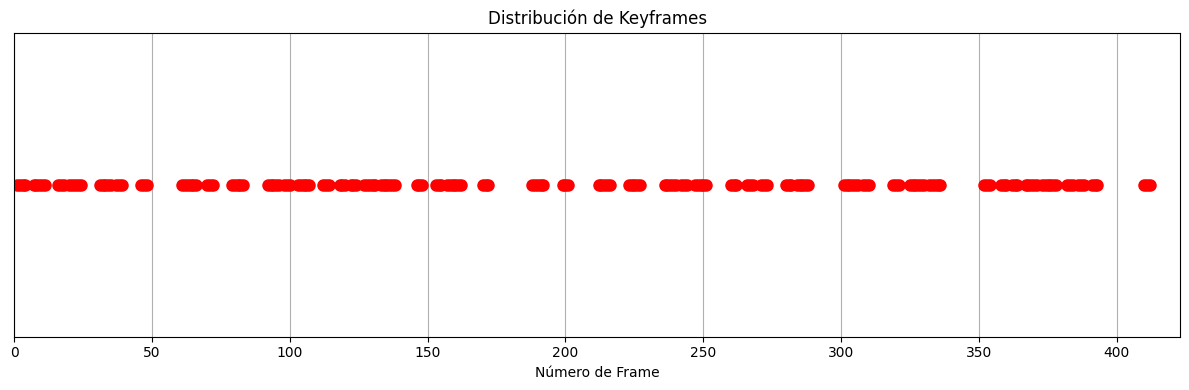

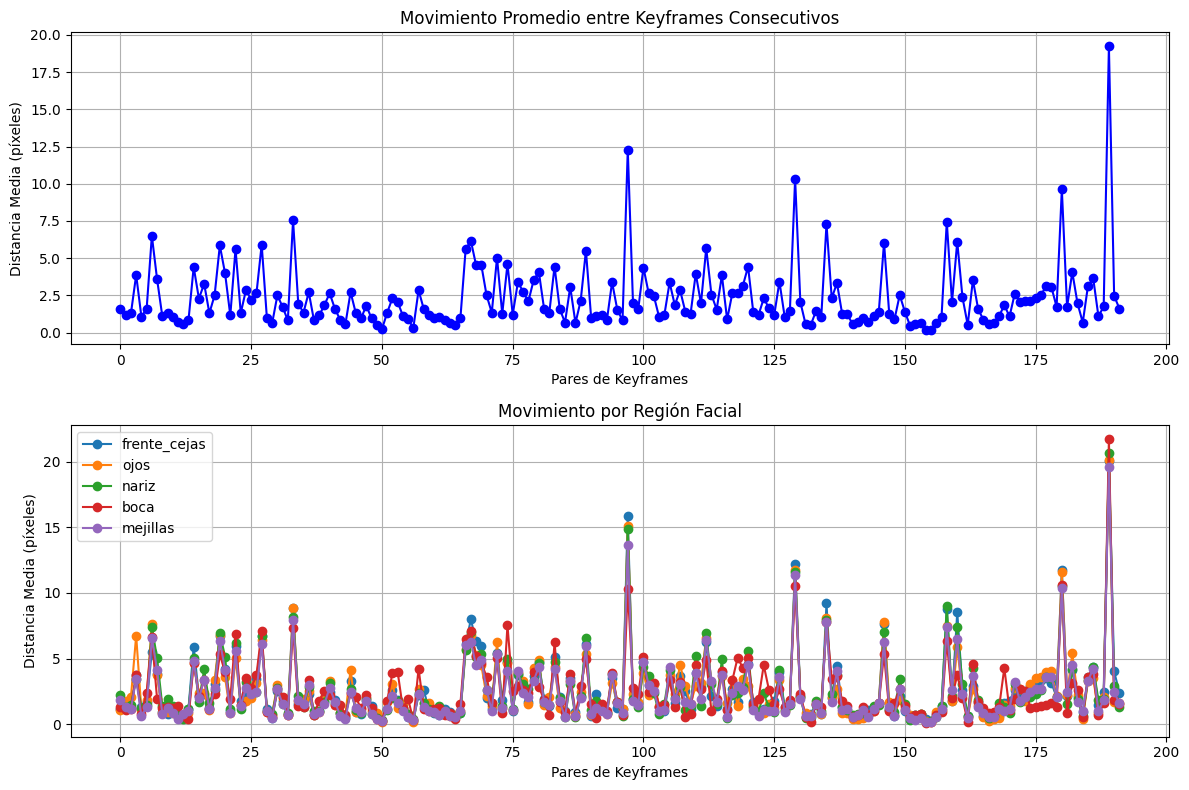

In [16]:
def main(video_path, output_folder="output_keyframes", display=True):
    """Función principal que ejecuta todo el pipeline de detección de micro-expresiones"""
    print(f"Procesando video: {video_path}")
    print(f"Los resultados se guardarán en: {output_folder}")
    
    # Inicializar componentes
    processor = VideoProcessor()
    analyzer = ResultAnalyzer()
    
    # Procesar video
    keyframes, keyframe_indices = processor.process_video(video_path, output_folder, display)
    
    if not keyframes:
        print("No se detectaron keyframes")
        return
    
    # Mostrar estadísticas
    print(f"\nEstadísticas:")
    print(f"- Total de keyframes detectados: {len(keyframes)}")
    if len(keyframe_indices) > 1:
        gaps = np.diff(keyframe_indices)
        print(f"- Distancia promedio entre keyframes: {np.mean(gaps):.2f} frames")
        print(f"- Distancia mínima entre keyframes: {np.min(gaps)} frames")
        print(f"- Distancia máxima entre keyframes: {np.max(gaps)} frames")
    
    # Analizar movimiento en keyframes
    movement_data = analyzer.analyze_movement_patterns(keyframes, processor.landmarks_detector)
    
    # Visualizar resultados
    if display and keyframe_indices:
        # Obtener total de frames del video
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        
        # Mostrar distribución de keyframes
        plt_dist = analyzer.visualize_keyframe_distribution(keyframe_indices, total_frames)
        plt_dist.savefig(f"{output_folder}/keyframe_distribution.png")
        
        # Mostrar análisis de movimiento
        if movement_data:
            plt_movement = analyzer.plot_movement_analysis(movement_data)
            plt_movement.savefig(f"{output_folder}/movement_analysis.png")
        
        print(f"\nGráficos de análisis guardados en {output_folder}")
    
    return keyframes, keyframe_indices

# Ejemplo de uso
if __name__ == "__main__":
    video_path = "C:/Users/Invitado/Documents/Tesis/Github/Tesis/llorando.mp4"  # Cambia esto por la ruta a tu video
    main(video_path)